# **Feed Forward Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0001
- Layers: [256, 128, 64]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_1s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [4]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/FFNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **Feed Forward Model**

In [9]:
def build_model(input_features,
                hidden_layers=[256, 128, 64],
                learning_rate=0.0001,
                output_units=20,
                dropout_rate=0.3):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_1s_model_training_history_2D_annotated.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [13]:
training_features_3D = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['cqt'], train_features['melspectrogram']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 21228)

In [14]:
validation_features_3D = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['cqt'], val_features['melspectrogram']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 21228)

In [15]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3113 - loss: 2.5513 - val_accuracy: 0.5832 - val_loss: 1.3054
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5347 - loss: 1.6024 - val_accuracy: 0.6462 - val_loss: 1.2187
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6143 - loss: 1.2922 - val_accuracy: 0.6555 - val_loss: 1.1958
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6708 - loss: 1.0970 - val_accuracy: 0.6878 - val_loss: 1.0767
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7055 - loss: 0.9849 - val_accuracy: 0.6893 - val_loss: 1.0878
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7390 - loss: 0.8643 - val_accuracy: 0.6760 - val_loss: 1.1427
Epoch 7/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7512 - loss: 0.8082 - val_accuracy: 0.6808 - val_loss: 1.1172
Epoch 8/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7791 - loss: 0.7231 - val_ac

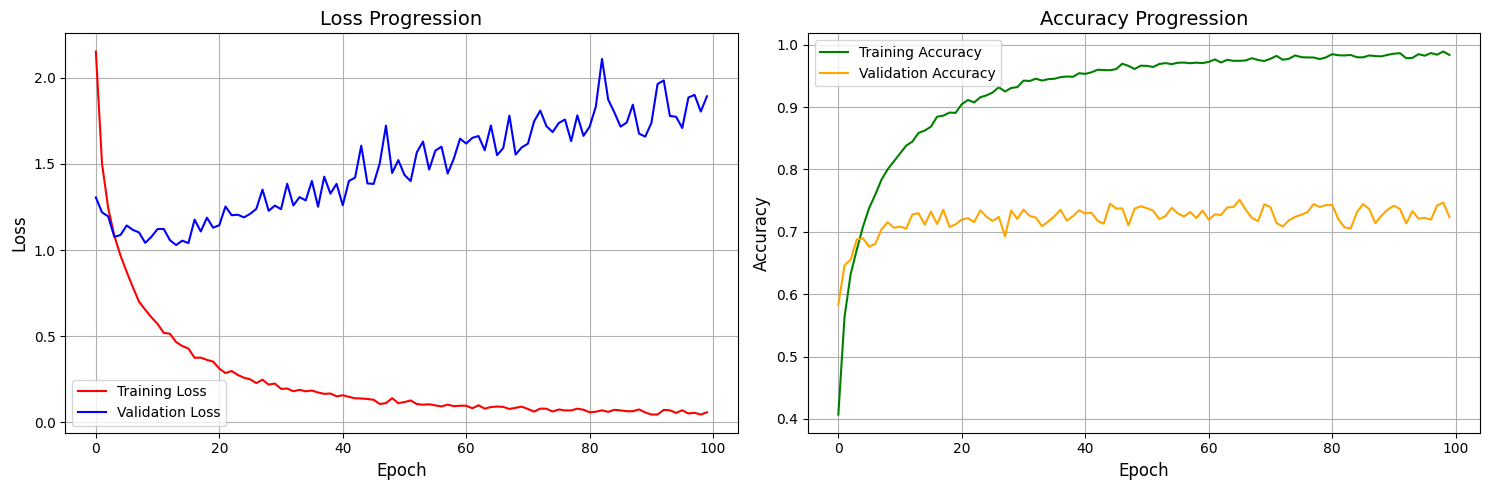

In [16]:
visualize(history, 'all_features')

In [17]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 9.5830e-04
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7264 - loss: 1.8299


In [18]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       455
           1       0.56      0.61      0.58       492
           2       0.83      0.75      0.79       889
           3       0.80      1.00      0.89       150
           4       0.81      0.31      0.45        67
           5       0.61      0.53      0.57        43
           6       0.28      0.29      0.29        24
           7       0.98      1.00      0.99        44
           8       0.64      0.84      0.72        50
           9       0.92      0.98      0.95       169
          10       0.54      0.85      0.66        53
          11       0.68      0.62      0.65        66
          12       0.75      0.78      0.77        59
          13       0.76      0.65      0.70        57
          14       0.70      0.82      0.76        38
          15       0.55      0.51      0.53       311
          16       1.00      0.96      0.98   

### Mel Spectrogram and Chroma

In [19]:
training_features_3D = np.concatenate((train_features['melspectrogram'], train_features['chroma']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 12180)

In [20]:
validation_features_3D = np.concatenate((val_features['melspectrogram'], val_features['chroma']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 12180)

In [21]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

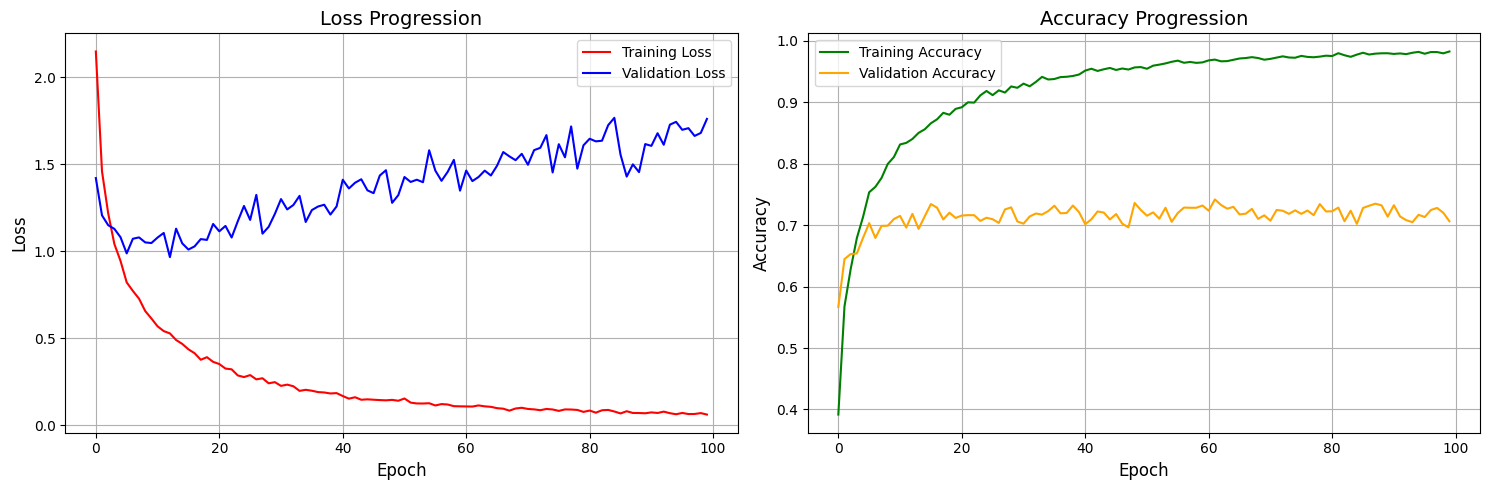

In [22]:
visualize(history, 'melspectrogram_chroma')

In [23]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 8.1511e-04
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7058 - loss: 1.7608


In [24]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       455
           1       0.53      0.50      0.52       492
           2       0.80      0.72      0.76       889
           3       0.80      0.91      0.85       150
           4       0.80      0.18      0.29        67
           5       0.45      0.12      0.19        43
           6       0.19      0.33      0.24        24
           7       1.00      0.95      0.98        44
           8       0.74      0.78      0.76        50
           9       0.90      0.94      0.92       169
          10       0.70      0.79      0.74        53
          11       0.56      0.70      0.62        66
          12       0.42      0.63      0.50        59
          13       0.63      0.70      0.67        57
          14       0.53      0.84      0.65        38
          15       0.57      0.59      0.58       311
          16       0.95      0.98      0.96   

### With Mel Spectrogram, MFCCs and Chroma

In [25]:
training_features_3D = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 13920)

In [26]:
validation_features_3D = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 13920)

In [27]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

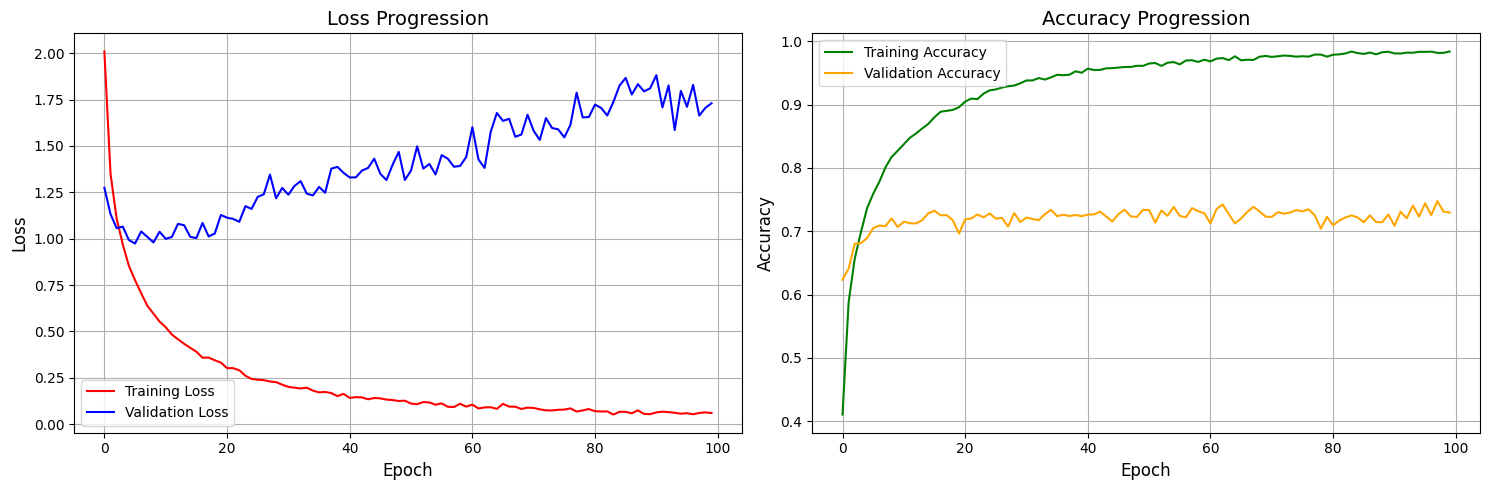

In [28]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [29]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0012
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7307 - loss: 1.7012


In [30]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       455
           1       0.58      0.50      0.54       492
           2       0.80      0.75      0.77       889
           3       0.89      0.97      0.93       150
           4       0.94      0.45      0.61        67
           5       0.53      0.40      0.45        43
           6       0.24      0.33      0.28        24
           7       0.96      1.00      0.98        44
           8       0.69      0.72      0.71        50
           9       0.90      0.93      0.92       169
          10       0.71      0.74      0.72        53
          11       0.64      0.58      0.61        66
          12       0.55      0.69      0.61        59
          13       0.56      0.74      0.64        57
          14       0.53      0.89      0.67        38
          15       0.62      0.62      0.62       311
          16       0.98      1.00      0.99   

### With Mel Spectrogram and MFCCs

In [31]:
training_features_3D = np.concatenate((train_features['melspectrogram'], train_features['mfcc']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 12876)

In [32]:
validation_features_3D = np.concatenate((val_features['melspectrogram'], val_features['mfcc']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 12876)

In [33]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

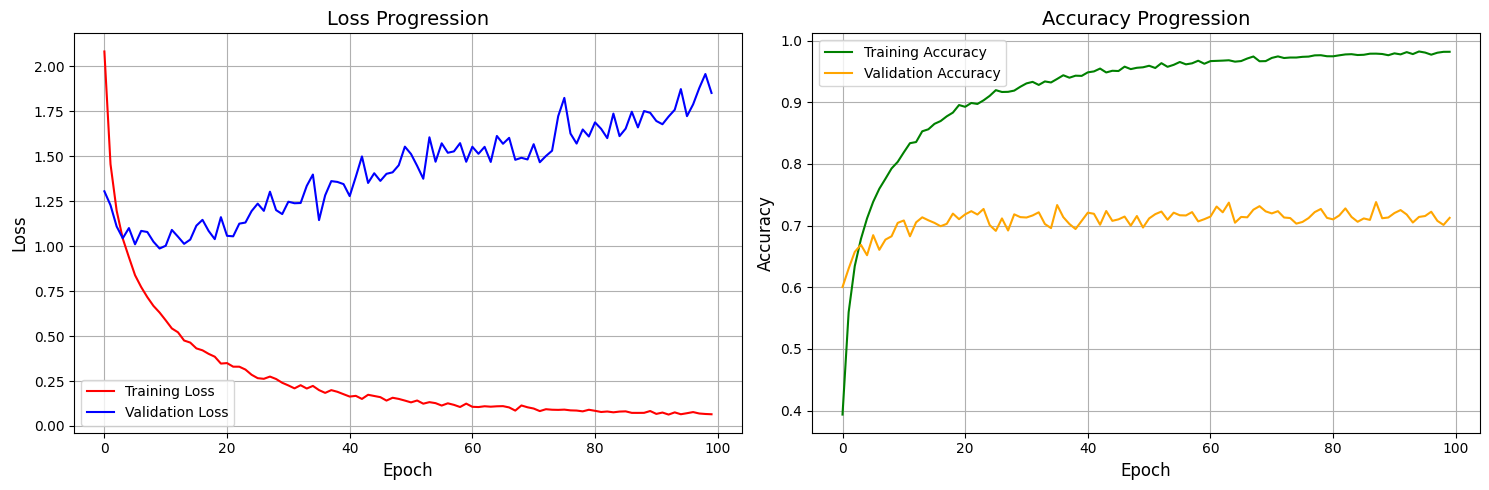

In [34]:
visualize(history, 'mfcc_melspectrogram')

In [35]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.0014
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7214 - loss: 1.7767


In [36]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       455
           1       0.60      0.52      0.56       492
           2       0.79      0.78      0.79       889
           3       0.82      0.99      0.90       150
           4       0.57      0.06      0.11        67
           5       0.29      0.12      0.17        43
           6       0.21      0.33      0.26        24
           7       0.98      0.98      0.98        44
           8       0.56      0.66      0.61        50
           9       0.94      0.86      0.90       169
          10       0.58      0.57      0.57        53
          11       0.50      0.29      0.37        66
          12       0.40      0.73      0.51        59
          13       0.51      0.74      0.60        57
          14       0.65      0.84      0.74        38
          15       0.64      0.67      0.65       311
          16       0.93      0.98      0.96   

### With Mel Spectrogram

In [37]:
training_features_3D =  train_features['melspectrogram']
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 11136)

In [38]:
validation_features_3D = val_features['melspectrogram']
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 11136)

In [39]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

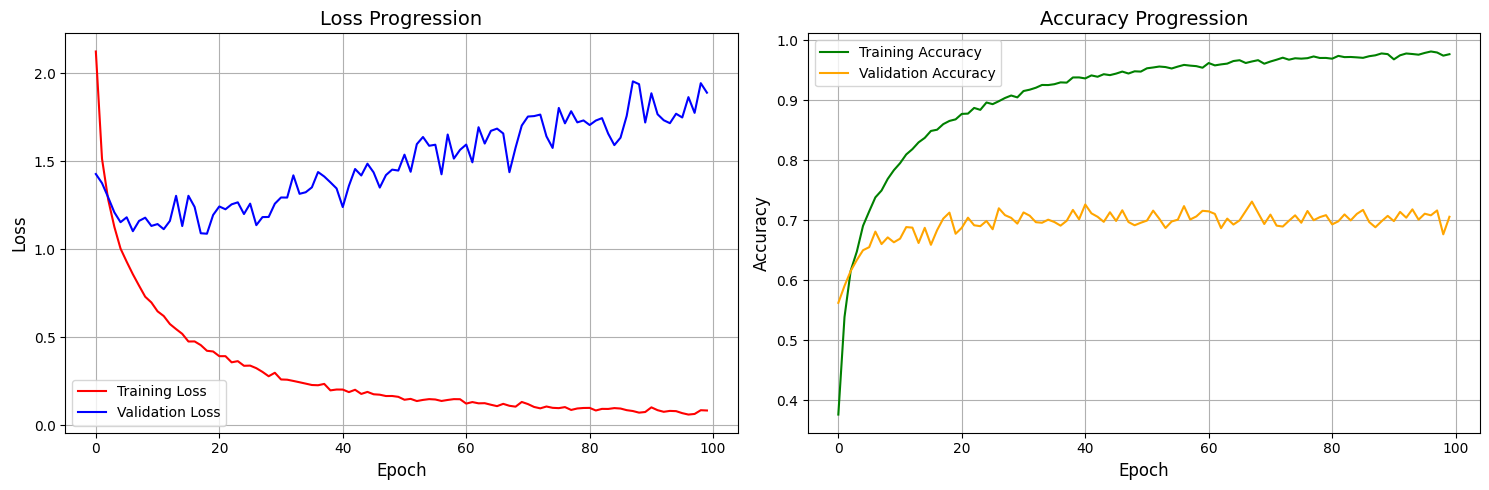

In [40]:
visualize(history, 'melspectrogram')

In [41]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0017
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7099 - loss: 1.8368


In [42]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       455
           1       0.58      0.45      0.51       492
           2       0.76      0.82      0.79       889
           3       0.87      0.99      0.93       150
           4       0.73      0.16      0.27        67
           5       0.22      0.09      0.13        43
           6       0.18      0.38      0.24        24
           7       0.96      0.98      0.97        44
           8       0.61      0.70      0.65        50
           9       0.92      0.92      0.92       169
          10       0.77      0.38      0.51        53
          11       0.57      0.42      0.49        66
          12       0.42      0.73      0.53        59
          13       0.60      0.61      0.61        57
          14       0.48      0.79      0.59        38
          15       0.54      0.51      0.53       311
          16       0.92      1.00      0.96   

## Review all the results

In [43]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,1.0,0.723
4,melspectrogram,1.0,0.706
1,melspectrogram_chroma,1.0,0.706
2,melspectrogram_chroma_mfcc,1.0,0.730
3,mfcc_melspectrogram,1.0,0.712


In [44]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.722      0.941
4              melspectrogram     0.697      0.939
1       melspectrogram_chroma     0.702      0.942
2  melspectrogram_chroma_mfcc     0.728      0.947
3         mfcc_melspectrogram     0.704      0.941
